# Data loading

In [9]:
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784')

X = mnist.data[:1000]
y = mnist.target[:1000]

X.shape

(1000, 784)

# Building simple Neural Network with one hidden layer and default parameters

In [10]:
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import KFold
import numpy as np
kf = KFold(n_splits=20, shuffle=True, random_state=42)

In [12]:
from sklearn.model_selection import RandomizedSearchCV

# Define the parameter distribution for 3-layer network
param_dist = {
    'hidden_layer_sizes': [
        (100, 50, 20),
        (128, 64, 32),
        (150, 100, 50),
        (64, 32, 16),
        (200, 100, 50)
    ],
    'activation': ['relu', 'tanh', 'logistic'],
    'solver': ['adam', 'sgd'],
    'alpha': [0.0001, 0.001, 0.01],
    'learning_rate': ['constant', 'invscaling', 'adaptive'],
    'learning_rate_init': [0.001, 0.01, 0.1],
    'momentum': [0.9, 0.8, 0.7],
    'nesterovs_momentum': [True, False],
    'beta_1': [0.9, 0.85, 0.95],
    'beta_2': [0.999, 0.990, 0.995],
    'epsilon': [1e-8, 1e-7, 1e-9],
    'early_stopping': [True, False]
}

mlp = MLPClassifier(max_iter=200, tol=1e-4, random_state=42)

# Run RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=mlp,
    param_distributions=param_dist,
    n_iter=20,
    cv=20,
    scoring='accuracy',
    n_jobs=-1,
    random_state=42
)

random_search.fit(X, y)

print("Best parameters found:", random_search.best_params_)
print("Best cross-validation accuracy: {:.4f}".format(random_search.best_score_))

/home/nykfer/projects/data-science/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/nykfer/projects/data-science/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/nykfer/projects/data-science/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/nykfer/projects/data-science/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization has

Best parameters found: {'solver': 'adam', 'nesterovs_momentum': False, 'momentum': 0.9, 'learning_rate_init': 0.01, 'learning_rate': 'adaptive', 'hidden_layer_sizes': (200, 100, 50), 'epsilon': 1e-09, 'early_stopping': False, 'beta_2': 0.99, 'beta_1': 0.95, 'alpha': 0.01, 'activation': 'logistic'}
Best cross-validation accuracy: 0.8150


In [16]:
params = random_search.best_params_
del params['hidden_layer_sizes']

In [20]:
from scipy.stats import uniform
from scipy.stats import randint

best_nn = MLPClassifier(**params)

np.random.seed(42)
hidden_layer_options = [
    (randint(100, 200).rvs(), randint(5, 251).rvs()) 
    for _ in range(10)  # Generate 50 random tuples
]

param_dicr = {
    'hidden_layer_sizes': hidden_layer_options
}

# Run RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=mlp,
    param_distributions=param_dicr,
    n_iter=20,
    cv=20,
    scoring='accuracy',
    n_jobs=-1,
    random_state=42
)

random_search.fit(X, y)

print("Best parameters found:", random_search.best_params_)
print("Best cross-validation accuracy: {:.4f}".format(random_search.best_score_))

# Create a DataFrame with all results
import pandas as pd
results_df = pd.DataFrame(random_search.cv_results_)
print("All cross-validation results:")
print(results_df)


/home/nykfer/projects/data-science/.venv/lib/python3.12/site-packages/sklearn/model_selection/_search.py:317: UserWarning: The total space of parameters 10 is smaller than n_iter=20. Running 10 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Best parameters found: {'hidden_layer_sizes': (187, 121)}
Best cross-validation accuracy: 0.8400
All cross-validation results:
   mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0       7.946651      0.393512         0.036839        0.008158   
1       6.349571      0.397214         0.036429        0.009756   
2       8.309533      0.474343         0.040449        0.008166   
3       6.546609      0.457018         0.036319        0.008999   
4       9.320364      0.582206         0.045075        0.014842   
5       9.546180      0.353173         0.046005        0.011298   
6       8.267594      0.662847         0.046148        0.013746   
7       9.787854      0.554482         0.058196        0.025285   
8       6.659144      0.560035         0.051489        0.024165   
9       5.940431      0.983746         0.040695        0.024906   

  param_hidden_layer_sizes                              params  \
0                (151, 97)   {'hidden_layer_sizes': (151, 97)}   
1  

In [21]:
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42, shuffle=True)

minmax = MinMaxScaler()
scaler = StandardScaler()

pipe_sc = Pipeline(
    [
        ('scaler', scaler),
        ('model', random_search.best_estimator_)
    ]
)

pipe_sc.fit(X_train, y_train)
accuracy_sc = accuracy_score(y_test, pipe_sc.predict(X_test))

pipe_minmax = Pipeline(
    [
        ('scaler', minmax),
        ('model', random_search.best_estimator_)
    ]
)

pipe_minmax.fit(X_train, y_train)
accuracy_minmax = accuracy_score(y_test, pipe_sc.predict(X_test))

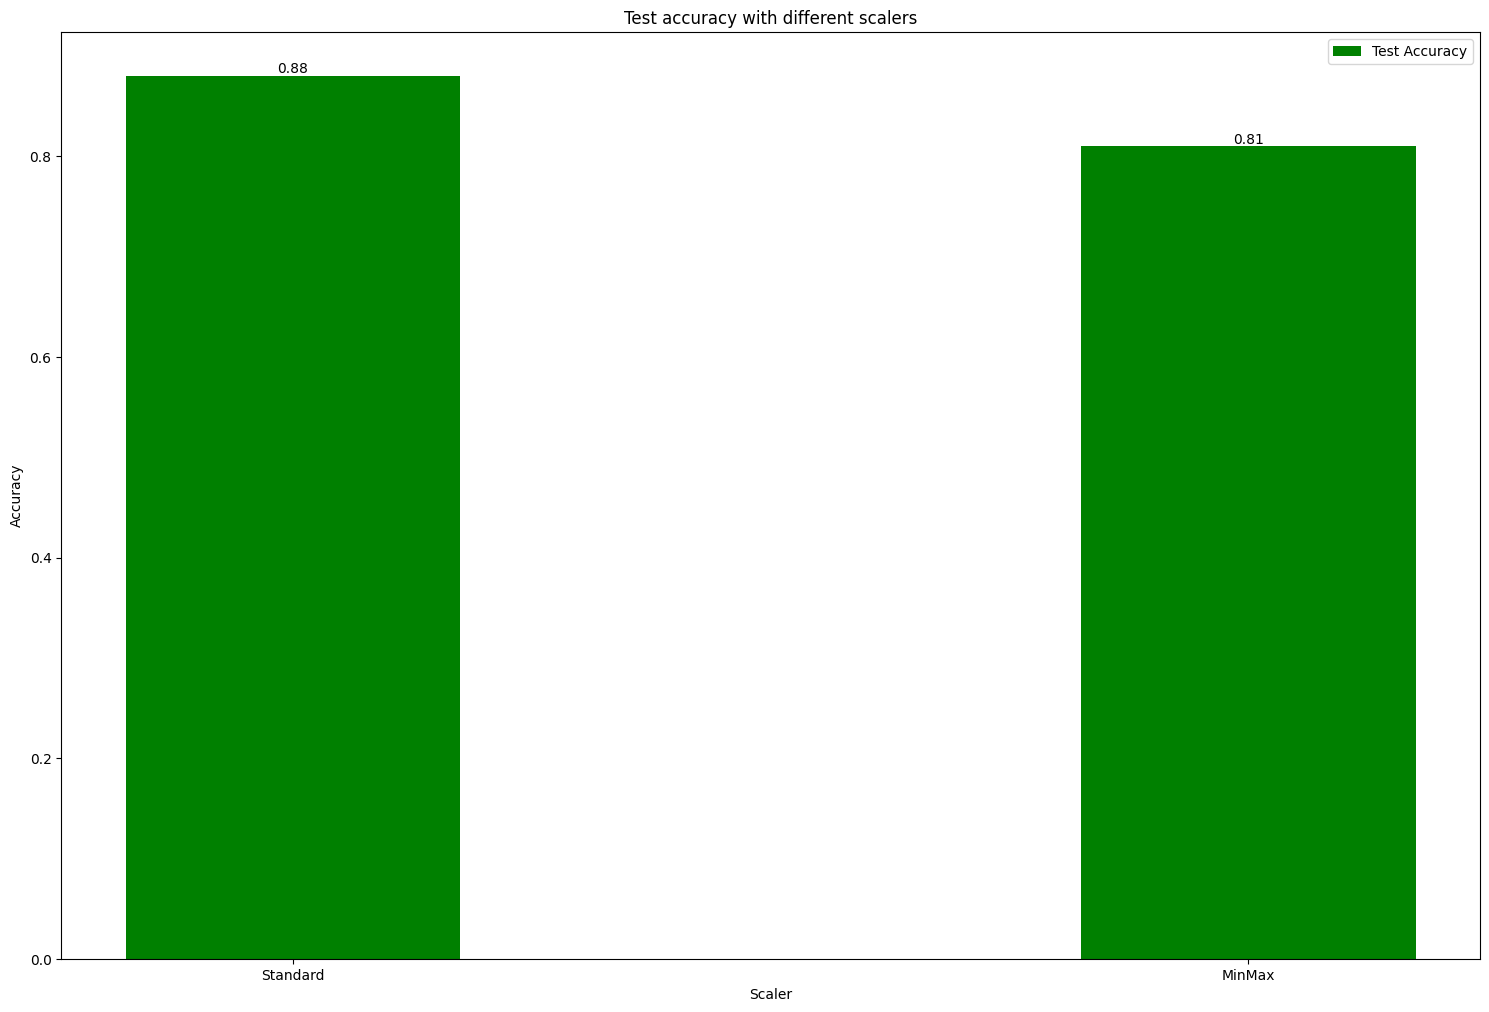

In [23]:
import matplotlib.pyplot as plt
import numpy as np

xs = ['Standard', 'MinMax']
x_pos = np.arange(len(xs))
width = 0.35

# Get the accuracies from the previous cell
accuracies = [accuracy_sc, accuracy_minmax]

fig, ax = plt.subplots(figsize=(15, 10))
bars1 = ax.bar(x_pos, accuracies, width, label='Test Accuracy', color='green')
ax.set_ylabel('Accuracy')
ax.set_xlabel('Scaler')
ax.set_xticks(x_pos)
ax.set_xticklabels(xs)
ax.legend()

for i, acc in enumerate(accuracies):
    ax.text(x_pos[i], acc, str(round(acc, 3)), ha='center', va='bottom')

plt.tight_layout()
plt.title('Test accuracy with different scalers')
plt.show()

In [24]:
best_nn = MLPClassifier(**params)

np.random.seed(42)
hidden_layer_options = [
    (187, 121, randint(5, 100).rvs()) 
    for _ in range(10)  # Generate 50 random tuples
]

param_dicr = {
    'model__hidden_layer_sizes': hidden_layer_options
}

best_pipe = Pipeline(
    [
        ('sclaer', scaler),
        ('model', best_nn)
    ]
)

# Run RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=best_pipe,
    param_distributions=param_dicr,
    n_iter=20,
    cv=20,
    scoring='accuracy',
    n_jobs=-1,
    random_state=42
)

random_search.fit(X, y)

print("Best parameters found:", random_search.best_params_)
print("Best cross-validation accuracy: {:.4f}".format(random_search.best_score_))

# Create a DataFrame with all results
import pandas as pd
results_df = pd.DataFrame(random_search.cv_results_)
print("All cross-validation results:")
print(results_df)


/home/nykfer/projects/data-science/.venv/lib/python3.12/site-packages/sklearn/model_selection/_search.py:317: UserWarning: The total space of parameters 10 is smaller than n_iter=20. Running 10 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Best parameters found: {'model__hidden_layer_sizes': (187, 121, 79)}
Best cross-validation accuracy: 0.8530
All cross-validation results:
   mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0      21.274631      2.077130         0.049268        0.013287   
1      22.513018      1.776781         0.050779        0.018736   
2      20.571877      5.492784         0.053946        0.018610   
3      21.796243      1.505903         0.050023        0.016077   
4      22.359799      1.445834         0.049705        0.010987   
5      20.679810      1.390362         0.054162        0.015361   
6      23.069496      2.294866         0.053671        0.010617   
7      23.109628      2.134344         0.053431        0.012685   
8      22.725700      1.546214         0.054357        0.016964   
9      22.060589      1.450103         0.042008        0.019687   

  param_model__hidden_layer_sizes  \
0                  (187, 121, 56)   
1                  (187, 121, 97)   
2            

In [29]:
best_nn = MLPClassifier(**params)

np.random.seed(42)
hidden_layer_options = [
    (randint(150, 200).rvs(), randint(100, 150).rvs(), randint(50, 100).rvs(), randint(5, 50).rvs()) 
    for _ in range(10)  # Generate 50 random tuples
]

param_dicr = {
    'model__hidden_layer_sizes': hidden_layer_options
}

best_pipe = Pipeline(
    [
        ('sclaer', scaler),
        ('model', best_nn)
    ]
)

# Run RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=best_pipe,
    param_distributions=param_dicr,
    n_iter=20,
    cv=20,
    scoring='accuracy',
    n_jobs=-1,
    random_state=42
)

random_search.fit(X, y)

print("Best parameters found:", random_search.best_params_)
print("Best cross-validation accuracy: {:.4f}".format(random_search.best_score_))


/home/nykfer/projects/data-science/.venv/lib/python3.12/site-packages/sklearn/model_selection/_search.py:317: UserWarning: The total space of parameters 10 is smaller than n_iter=20. Running 10 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
/home/nykfer/projects/data-science/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/nykfer/projects/data-science/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Best parameters found: {'model__hidden_layer_sizes': (174, 148, 76, 46)}
Best cross-validation accuracy: 0.8460
